1. Token level perplexity in training set |

In [1]:
import os, torch 
from model import GPT, GPTConfig 

# Data Filter Issue: Missing character & number & symbols 
# - desired character set: 
all_chars = '''abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ ⏎'''

device = "cpu"
out_dir = "checkpoint/base"
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)

model = GPT.load_model(checkpoint, device)

number of parameters: 10.66M


/var/folders/nn/nbsb8w3570zfgs23h2s0cdzm0000gn/T/ipykernel_7829/2830301627.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_locati

Initialize Dynamic Tokenizer

In [9]:
# load tokenizer functional 
import pickle
meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)
stoi, itos = meta['stoi'], meta['itos']

from src.etoken import ETokenizer 

tok = ETokenizer(char_vocab=itos)

# end-of-merge tokens could be used to update wte/lm_head (initialize embedding/projection for new tokens)
eom_tokens = tok.add_tokens([[1,2], [1,3], [1, 4], [1, 2, 3, 4]], return_eom=True) 

tok.split_tokens([90]) # re-ordered into consecutive indices, nice 


tok.add_tokens([[1,2]])

encode = lambda s: tok.encode(s)
decode = lambda l: tok.decode(l)

 :: prefix_token:     :: prefix token idx:  1
 :: curr_token:  !  :: curr token idx:  2
 :: new_token:   !
 :: Adding new token:   !  with idx:  90
 :: prefix_token:     :: prefix token idx:  1
 :: curr_token:  #  :: curr token idx:  3
 :: new_token:   #
 :: Adding new token:   #  with idx:  91
 :: prefix_token:     :: prefix token idx:  1
 :: curr_token:  $  :: curr token idx:  4
 :: new_token:   $
 :: Adding new token:   $  with idx:  92
 :: prefix_token:     :: prefix token idx:  1
 :: curr_token:  !  :: curr token idx:  2
 :: new_token:   !
 :: new_token already exists
 :: prefix_token:   !  :: prefix token idx:  90
 :: curr_token:  #  :: curr token idx:  3
 :: new_token:   !#
 :: Adding new token:   !#  with idx:  93
 :: prefix_token:   !#  :: prefix token idx:  93
 :: curr_token:  $  :: curr token idx:  4
 :: new_token:   !#$
 :: Adding new token:   !#$  with idx:  94
 :: Removed tokens:  [90]
 :: prefix_token:     :: prefix token idx:  1
 :: curr_token:  !  :: curr token idx:  2

In [11]:
# Issue: 
# - When grouping tokens, pair-wise merges is added to the tokenizer, yet wte/lm_head is not updated to match this
# - When removing tokens, .merges and .vocab are not updated to have consecutive indices
# tok.merges
tok.vocab

{0: '\n',
 1: ' ',
 2: '!',
 3: '#',
 4: '$',
 5: '%',
 6: "'",
 7: '(',
 8: ')',
 9: '*',
 10: '+',
 11: ',',
 12: '-',
 13: '.',
 14: '/',
 15: '0',
 16: '1',
 17: '2',
 18: '3',
 19: '4',
 20: '5',
 21: '6',
 22: '7',
 23: '8',
 24: '9',
 25: ':',
 26: ';',
 27: '=',
 28: '?',
 29: '@',
 30: 'A',
 31: 'B',
 32: 'C',
 33: 'D',
 34: 'E',
 35: 'F',
 36: 'G',
 37: 'H',
 38: 'I',
 39: 'J',
 40: 'K',
 41: 'L',
 42: 'M',
 43: 'N',
 44: 'O',
 45: 'P',
 46: 'Q',
 47: 'R',
 48: 'S',
 49: 'T',
 50: 'U',
 51: 'V',
 52: 'W',
 53: 'X',
 54: 'Y',
 55: 'Z',
 56: '\\',
 57: '^',
 58: '_',
 59: '`',
 60: 'a',
 61: 'b',
 62: 'c',
 63: 'd',
 64: 'e',
 65: 'f',
 66: 'g',
 67: 'h',
 68: 'i',
 69: 'j',
 70: 'k',
 71: 'l',
 72: 'm',
 73: 'n',
 74: 'o',
 75: 'p',
 76: 'q',
 77: 'r',
 78: 's',
 79: 't',
 80: 'u',
 81: 'v',
 82: 'w',
 83: 'x',
 84: 'y',
 85: 'z',
 86: '{',
 87: '|',
 88: '}',
 89: '~',
 90: ' #',
 91: ' $',
 92: ' !#',
 93: ' !#$',
 94: ' !'}

In [3]:
import torch 
from src.utils import calculate_bits_per_char

text = "DeepSeek's architectural innovations MoE, MLA, MTP, and FP3Quantization focus on optimizing largescale training and deployment and serving efficiency."

token_ids = torch.tensor(encode(text)).view(1, -1)
input_ids, target_ids = token_ids[:, :-1], token_ids[:, 1:]
logits, token_loss = model(input_ids, targets=target_ids, reduction='none') # loss is provided as an 'average' loss per token --- I want singular loss per token 
bpc_loss = calculate_bits_per_char(token_loss, target_ids, decode)

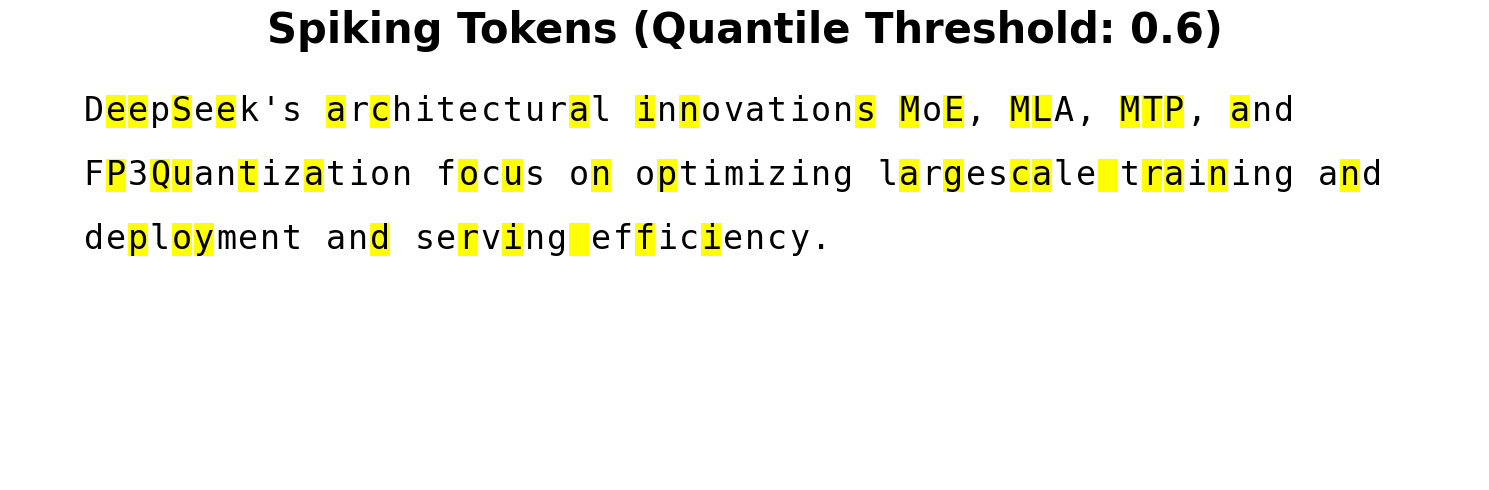

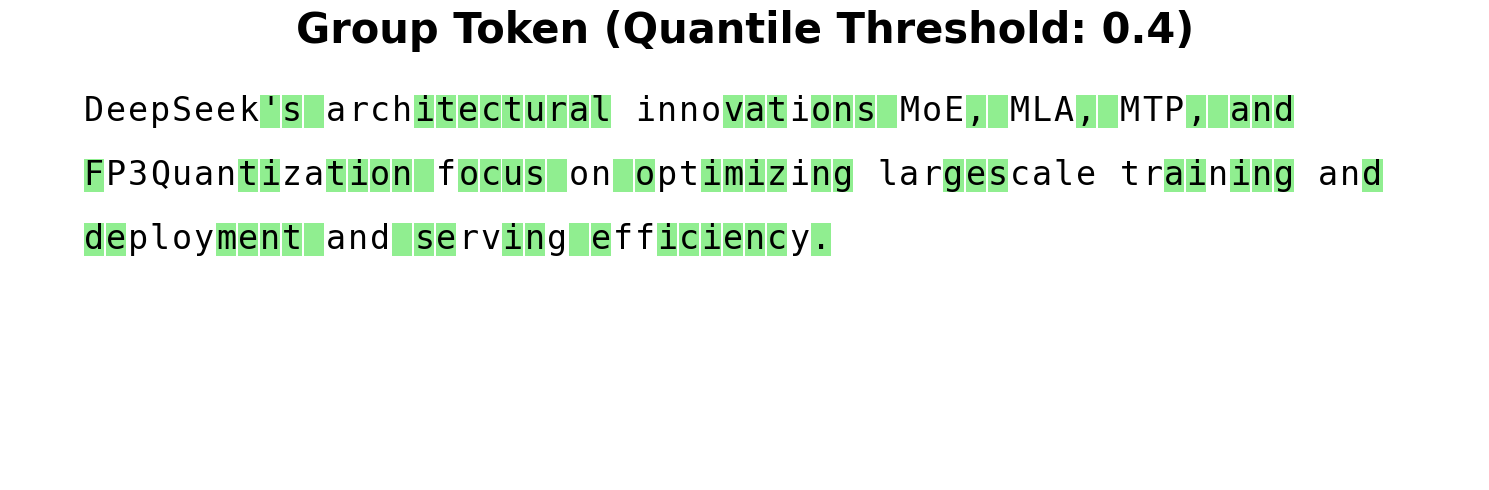

In [4]:
from src.vis import display_colored_text
from src.utils import shift_token_loss, map_token_to_char_perplexity, get_naive_char_color

token_perplexity = shift_token_loss(token_loss)
char_perplexity = map_token_to_char_perplexity(text, token_ids, token_perplexity, decode)

from src.grouping import get_spike_token_mask, get_group_token_mask

# (a). Spiking token visualization 
spike_quantile_threshold = 0.6
spike_token_mask = get_spike_token_mask(token_perplexity, quantile_threshold=spike_quantile_threshold)
char_perplexity, char_colors = map_token_to_char_perplexity(text, token_ids, token_perplexity, decode, spike_token_mask, mask_color='yellow')
display_colored_text(text, char_colors, title=f"Spiking Tokens (Quantile Threshold: {spike_quantile_threshold})")

# (b). Group token visualization 
group_quantile_threshold = 0.4
group_token_mask = get_group_token_mask(token_perplexity, quantile_threshold=group_quantile_threshold)
char_perplexity, char_colors = map_token_to_char_perplexity(text, token_ids, token_perplexity, decode, group_token_mask, mask_color='lightgreen')
display_colored_text(text, char_colors, title=f"Group Token (Quantile Threshold: {group_quantile_threshold})")

In [37]:
from src.grouping import detect_group_token, detect_spike_token
from src.embed import remove_token_lm_head, add_token_lm_head, remove_token_wte, add_token_wte

# Change on tokenizer marks the change to: tokenizer & transformer token embedding & language modeling head

def update_token(model, tok, token_ids, token_perplexity, spike_quantile_threshold, group_quantile_threshold):
    
    # (a). Spike token | Split 'spike tokens' -- removing these tokens and use sub-token units instead 
    tokens_to_split = detect_spike_token(token_ids, token_perplexity, quantile_threshold=spike_quantile_threshold)
    tokens_to_remove = tok.identify_splittable_tokens(tokens_to_split)
    tok.remove_tokens(tokens_to_remove)

    # (b). Group token | Merge 'group tokens' -- adding these tokens to the tokenizer
    tokens_to_group, group_positions = detect_group_token(token_ids, token_perplexity, quantile_threshold=group_quantile_threshold, return_indices=True)
    tok.add_tokens(tokens_to_group)

    # (c). Update LLM 'wte' | Use end-of-group representations to initialize new token embeddings
    eog_positions = [group[-1] for group in group_positions] # end-of-group indices
    representations = model.get_representation(input_ids) 
    group_token_embeddings = representations[-1][0, eog_positions] # end-of-group representations 
    add_wte = add_token_wte(model.transformer.wte, group_token_embeddings)
    new_wte = remove_token_wte(add_wte, tokens_to_remove) # Assumption: weights are ordered by token-idx

    # (d). Update LLM 'lm_head' | Use end-of-group token projection to initialize new token projection (should be average of group projection instead?)
    eog_tokens = [tokens[-1] for tokens in tokens_to_group] # end-of-group indices
    add_lm_head = add_token_lm_head(model.lm_head, init_indices=eog_tokens) # assume lm_head is ordered by token-idx (consecutive without skips)
    new_lm_head = remove_token_lm_head(add_lm_head, tokens_to_remove)
    
    model.transformer.wte = new_wte
    model.lm_head = new_lm_head
    return model, tok 

In [7]:
# Update on LLM token embedding table & classification head 
from src.embed import remove_token_wte, remove_token_lm_head, add_token_wte, add_token_lm_head 

# How to re-use existing token embeddings to initialize new token embeddings? 
# - Idea: Use the end-of-group representation as the new token's embedding - it incorporates informatoin of the grouped tokens 

wte = model.transformer.wte # token embedding table 
lm_head = model.lm_head # classification head

